### Préparation de l’environnement et imports


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Chargement des Données

In [ ]:
# Charger le dataset
dataset = pd.read_csv('insurance.csv')
df = dataset.copy()

# Premier aperçu
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### Informations générales  

In [ ]:
def section(title):
    print("\n" + "="*60)
    print(title)
    print("="*60 + "\n")


section("Dimention du dataset")
print(f"Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes\n")

section("Information générales du dataset")
df.info()

section("Statistiques descriptives")
df.describe()


Dimention du dataset

Dimensions : 1338 lignes × 7 colonnes


Information générales du dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Statistiques descriptives



,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Séparation des variables numériques et catégorielles

In [ ]:
# Variable cible
target = 'charges'

# Variables numériques
variables_numeriques = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Variables numériques  : {variables_numeriques}")

# Variables catégorielles
variables_categorielles = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variables catégorielles  : {variables_categorielles}")

Variables numériques  : ['age', 'bmi', 'children', 'charges']
Variables catégorielles  : ['sex', 'smoker', 'region']


###  Analyse univariée et bivariée



#### Distribution des Variables Numériques



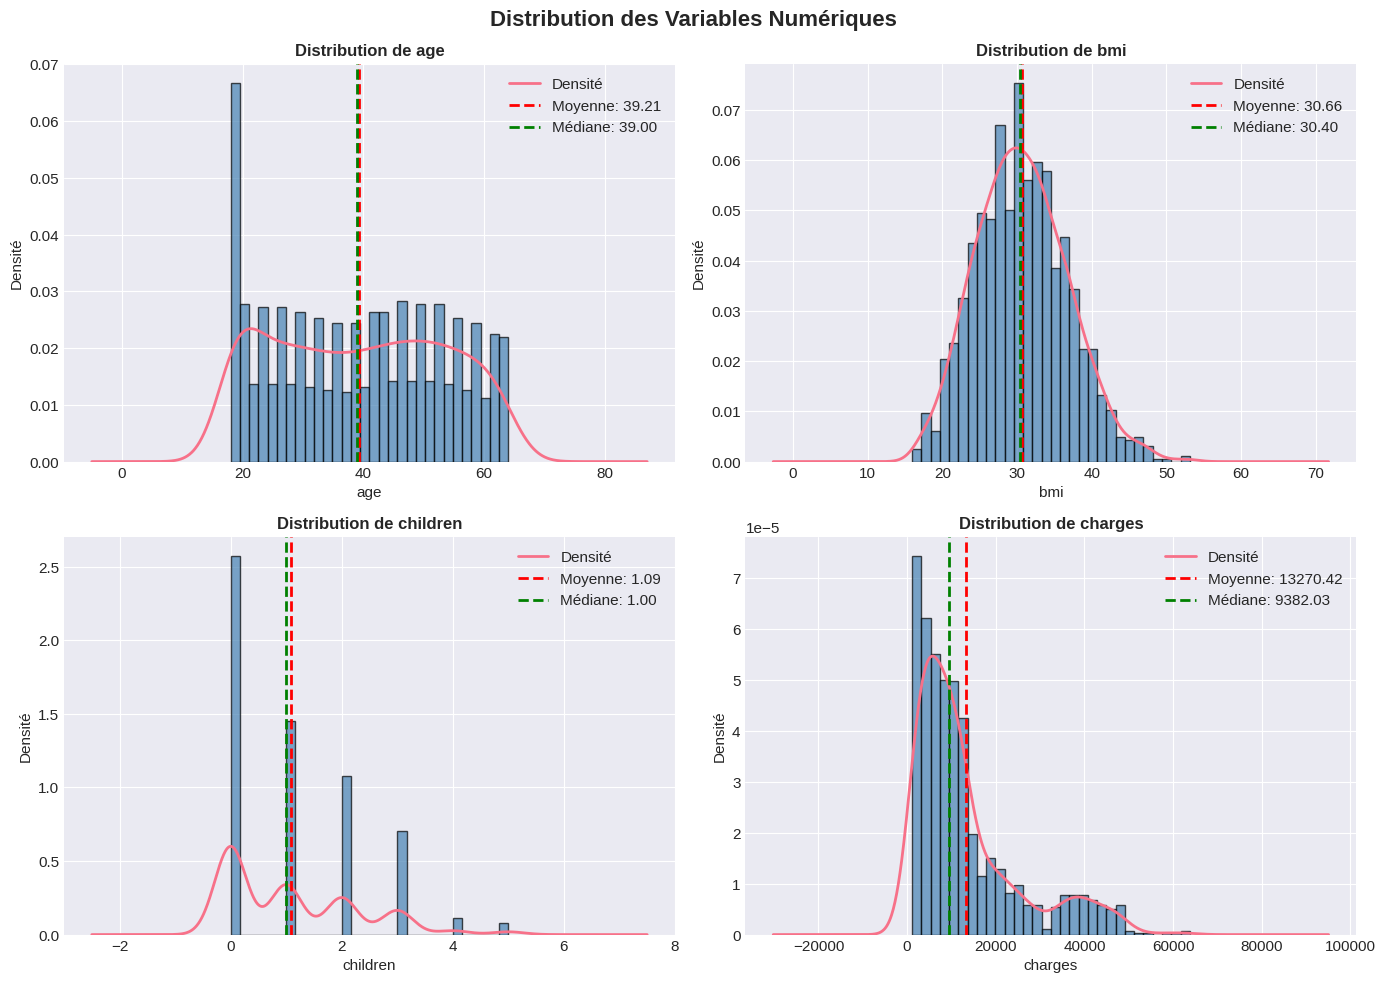

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution des Variables Numériques', fontsize=16, weight='bold')

axes = axes.flatten()

for i, col in enumerate(variables_numeriques):
    ax = axes[i]

    ax.hist(df[col], bins=30, color='steelblue',
            edgecolor='black', alpha=0.7, density=True)

    df[col].plot(kind='density', ax=ax, linewidth=2, label='Densité')

    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {df[col].mean():.2f}')
    ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {df[col].median():.2f}')

    ax.set_title(f'Distribution de {col}', fontsize=12, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Densité')
    ax.legend()

plt.tight_layout()
plt.show()

#### Détection des Outliers


In [ ]:
if target in variables_numeriques:
    variables_numeriques.remove(target)

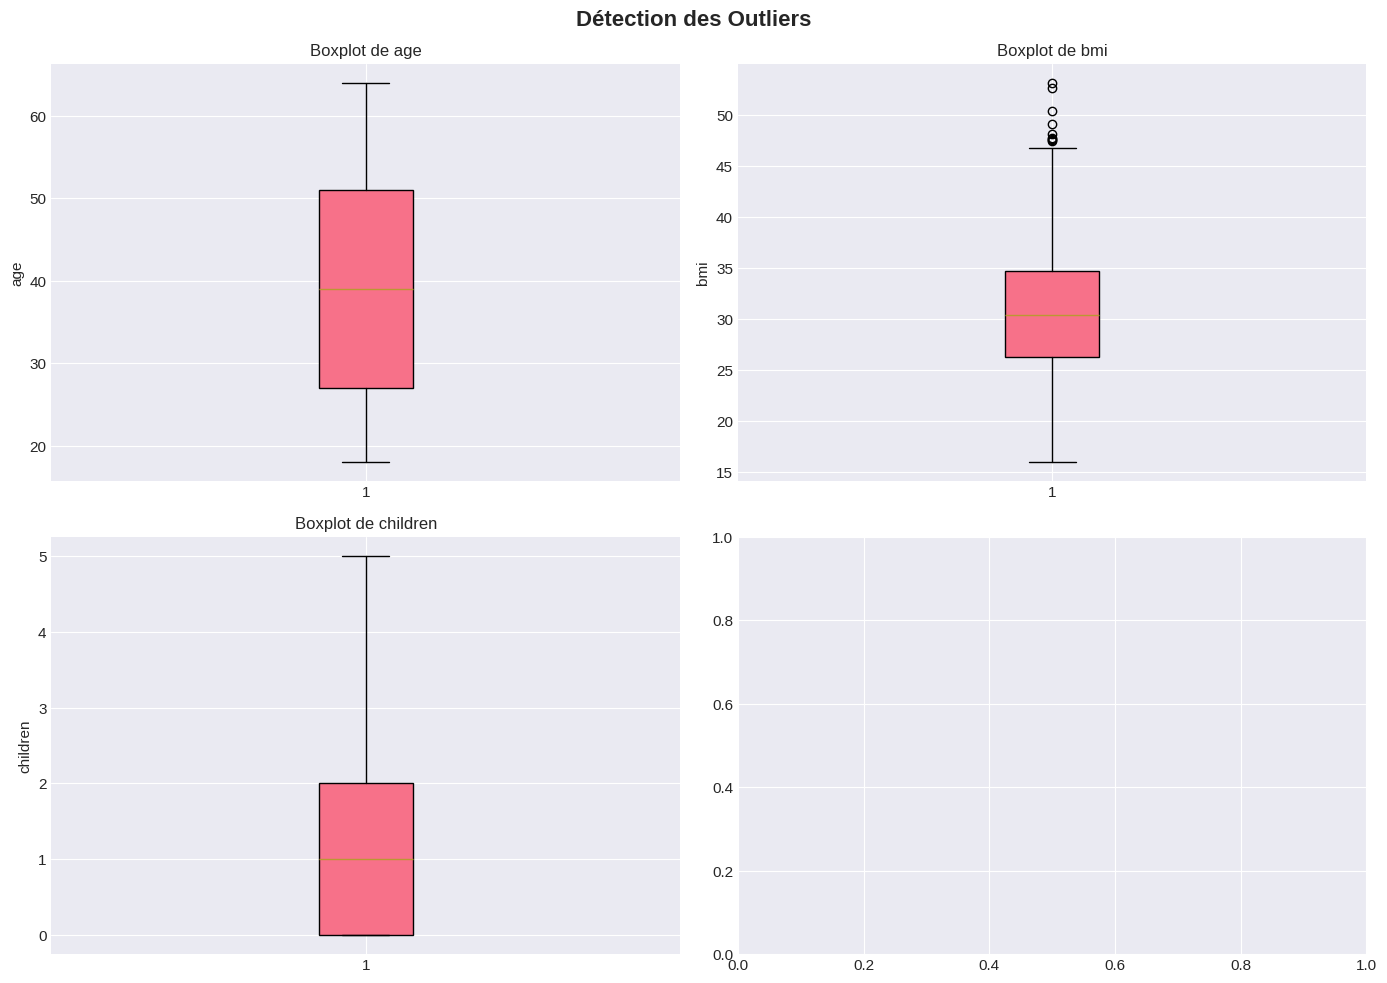

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Détection des Outliers', fontsize=16, weight='bold')

axes = axes.flatten()

for i, col in enumerate(variables_numeriques):
    ax = axes[i]

    ax.boxplot(df[col], patch_artist=True)

    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


In [ ]:
dictionaire_outliers = {}

for col in variables_numeriques:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    borne_inf = Q1 - 1.5 * IQR
    borne_sup = Q3 + 1.5 * IQR

    outliers = df[(df[col] < borne_inf) | (df[col] > borne_sup)][col]

    dictionaire_outliers[col] = outliers
    print("="*60)

    print(f"{col} : {len(outliers)} outliers")
    print(outliers.values)


age : 0 outliers
[]
bmi : 9 outliers
[49.06 48.07 47.52 47.41 50.38 47.6  52.58 47.74 53.13]
children : 0 outliers
[]


Analyse des outliers :

Les 9 valeurs de BMI sont très élevées par rapport aux autres et montrent des personnes avec une obésité très sévère.

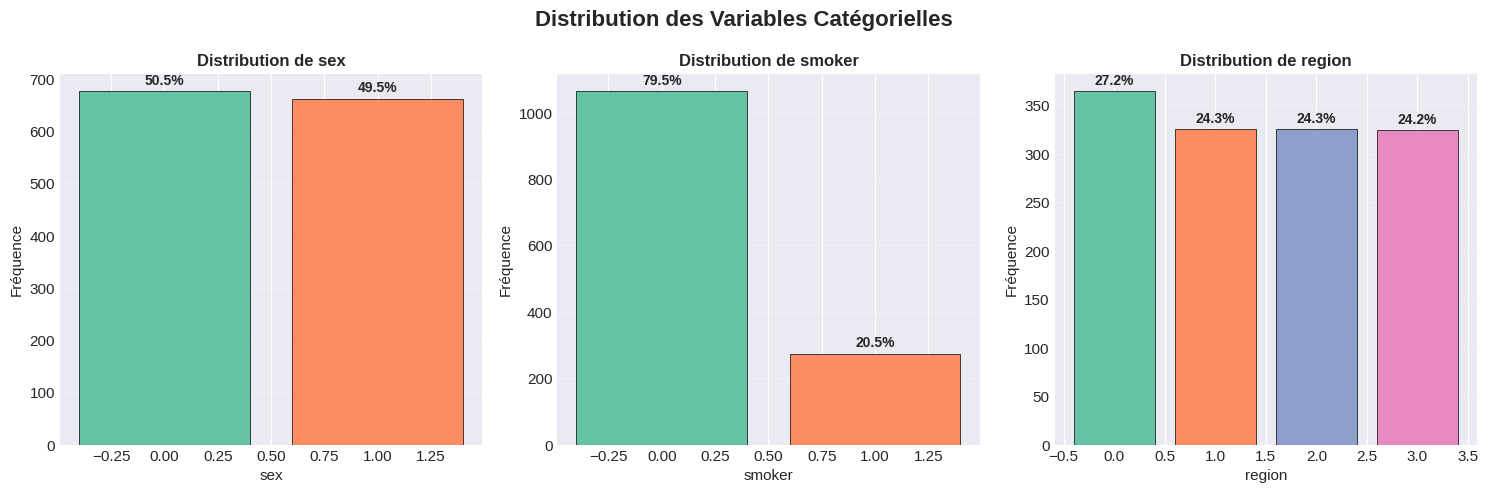

In [ ]:
n_cat = len(variables_categorielles)
fig, axes = plt.subplots(1, n_cat, figsize=(5*n_cat, 5))
fig.suptitle('Distribution des Variables Catégorielles', fontsize=16, weight='bold')

axes = np.atleast_1d(axes)

for idx, col in enumerate(variables_categorielles):
    ax = axes[idx]
    counts = df[col].value_counts()

    ax.bar(range(len(counts)), counts.values,
                  color=sns.color_palette("Set2", len(counts)),
                  edgecolor='black', linewidth=0.5)

    ax.set_title(f'Distribution de {col}', fontsize=12, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Fréquence')
    ax.grid(axis='y', alpha=0.3)

    # Ajouter les pourcentages sur les barres
    for i, v in enumerate(counts.values):
        pct = (v / len(df)) * 100
        ax.text(i, v + max(counts.values)*0.02, f'{pct:.1f}%',
                ha='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

 ### Analyse Bivariée - Corrélations

In [ ]:
if target not in variables_numeriques:
   variables_numeriques.append(target)

In [ ]:
print("Matrice de corrélation")
print("="*60)
corr_matrix = df[variables_numeriques].corr().round(2)
print(corr_matrix)

Matrice de corrélation
           age   bmi  children  charges
age       1.00  0.11      0.04     0.30
bmi       0.11  1.00      0.01     0.20
children  0.04  0.01      1.00     0.07
charges   0.30  0.20      0.07     1.00


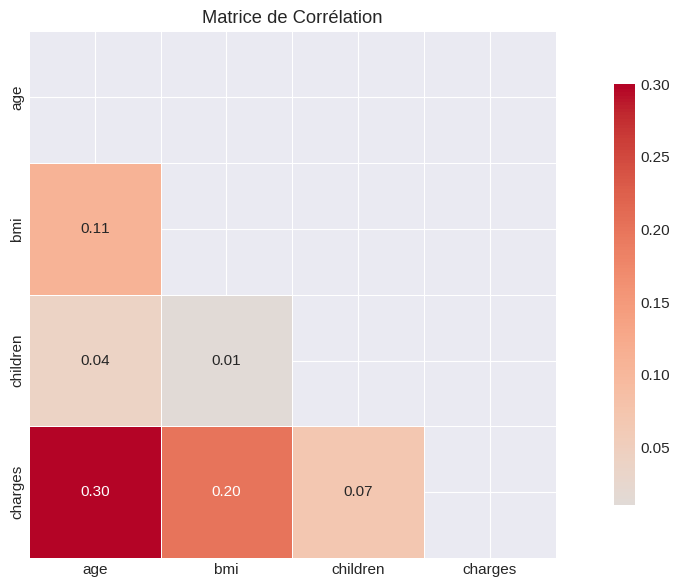

In [ ]:
# Création de la heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, mask=mask, cbar_kws={"shrink": .8},
            fmt='.2f', linewidths=0.5)

plt.title('Matrice de Corrélation')
plt.tight_layout()
plt.show()

Les charges augmentent un peu avec l’âge et le bmi, mais le nombre d’enfants n’a presque aucun effet, et les autres variables sont peu liées entre elles

###  Analyse Bivariée - Relations avec Les charges